In [1]:
import argparse
from collections import defaultdict, namedtuple
from io import open
import math
import os
from random import shuffle, uniform
from datetime import datetime
from future.utils import iterkeys, iteritems
import torch

from future.builtins import range
from future.utils import iteritems
import pickle
import numpy as np
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

In [2]:
# !pip install scipy
# !pip install matplotlib
# !pip install sklearn
!pip install torchsummaryX -q
from torchsummaryX import summary

In [3]:
import gc

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
#Get Glove Vectors
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip /content/glove.6B.zip

--2023-04-21 19:45:22--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-04-21 19:45:23--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.01MB/s    in 2m 39s  

2023-04-21 19:48:02 (5.17 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  /content/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
 

In [5]:
#Prepare Glove Vectors
word2vec = {}
with open("/content/glove.6B.50d.txt", 'r', encoding="utf-8") as f:
    for l in f:
        line = l.split()
        word = line[0]
        vect = np.array(line[1:]).astype(float)
        word2vec[word] = vect
pickle.dump(word2vec, open(f'/content/6B.50_word2Vec.pkl', 'wb'))

# Data Loading Utilities

In [6]:
class InstanceData(object):
    """
    A bare-bones class to store the included properties of each instance. This is meant to act as easy access to the
    data, and provides a launching point for deriving your own features from the data.
    """
    def __init__(self, instance_properties):

        # Parameters specific to this instance
        self.instance_id = instance_properties['instance_id']
        self.token = instance_properties['token']
        self.part_of_speech = instance_properties['part_of_speech']
        self.morphological_features = instance_properties['morphological_features']
        self.dependency_label = instance_properties['dependency_label']
        self.dependency_edge_head = instance_properties['dependency_edge_head']

        # Derived parameters specific to this instance
        self.exercise_index = int(self.instance_id[8:10])
        self.token_index = int(self.instance_id[10:12])

        # Derived parameters specific to this exercise
        self.exercise_id = self.instance_id[:10]

        # Parameters shared across the whole session
        self.user = instance_properties['user']
        self.countries = instance_properties['countries']
        self.days = instance_properties['days']
        self.client = instance_properties['client']
        self.session = instance_properties['session']
        self.format = instance_properties['format']
        self.time = instance_properties['time']
        self.prompt = instance_properties.get('prompt', None)

        # Derived parameters shared across the whole session
        self.session_id = self.instance_id[:8]

    def to_features(self):
        """
        Prepares those features that we wish to use in the LogisticRegression example in this file. We introduce a bias,
        and take a few included features to use. Note that this dict restructures the corresponding features of the
        input dictionary, 'instance_properties'.

        Returns:
            to_return: a representation of the features we'll use for logistic regression in a dict. A key/feature is a
                key/value pair of the original 'instance_properties' dict, and we encode this feature as 1.0 for 'hot'.
        """
        to_return = dict()

        to_return['bias'] = 1.0
        to_return['user:' + self.user] = 1.0
        to_return['format:' + self.format] = 1.0
        to_return['token:' + self.token.lower()] = 1.0

        to_return['part_of_speech:' + self.part_of_speech] = 1.0
        for morphological_feature in self.morphological_features:
            to_return['morphological_feature:' + morphological_feature] = 1.0
        to_return['dependency_label:' + self.dependency_label] = 1.0
        
        time = datetime.now()
        if(time.second %10 == 0 and time.microsecond == 0):
          print(time)
          
        return to_return

In [7]:
#Load data from the file
def load_data(filename):
    """
    This method loads and returns the data in filename. If the data is labelled training data, it returns labels too.

    Parameters:
        filename: the location of the training or test data you want to load.

    Returns:
        data: a list of InstanceData objects from that data type and track.
        labels (optional): if you specified training data, a dict of instance_id:label pairs.
    """

    # 'data' stores a list of 'InstanceData's as values.
    data = []

    # If this is training data, then 'labels' is a dict that contains instance_ids as keys and labels as values.
    training = False
    if filename.find('train') != -1:
        training = True

    if training:
        labels = dict()

    num_exercises = 0
    print('Loading instances...')
    instance_properties = dict()

    with open(filename, 'rt') as f:
        for line in f:
            line = line.strip()

            # If there's nothing in the line, then we're done with the exercise. Print if needed, otherwise continue
            if len(line) == 0:
                num_exercises += 1
                if num_exercises % 100000 == 0:
                    print('Loaded ' + str(len(data)) + ' instances across ' + str(num_exercises) + ' exercises...')
                instance_properties = dict()

            # If the line starts with #, then we're beginning a new exercise
            elif line[0] == '#':
                if 'prompt' in line:
                    instance_properties['prompt'] = line.split(':')[1]
                else:
                    list_of_exercise_parameters = line[2:].split()
                    for exercise_parameter in list_of_exercise_parameters:
                        [key, value] = exercise_parameter.split(':')
                        if key == 'countries':
                            value = value.split('|')
                        elif key == 'days':
                            value = float(value)
                        elif key == 'time':
                            if value == 'null':
                                value = None
                            else:
                                assert '.' not in value
                                value = int(value)
                        instance_properties[key] = value

            # Otherwise we're parsing a new Instance for the current exercise
            else:
                line = line.split()
                if training:
                    assert len(line) == 7
                else:
                    assert len(line) == 6
                assert len(line[0]) == 12

                instance_properties['instance_id'] = line[0]

                instance_properties['token'] = line[1]
                instance_properties['part_of_speech'] = line[2]

                instance_properties['morphological_features'] = dict()
                for l in line[3].split('|'):
                    [key, value] = l.split('=')
                    if key == 'Person':
                        value = int(value)
                    instance_properties['morphological_features'][key] = value

                instance_properties['dependency_label'] = line[4]
                instance_properties['dependency_edge_head'] = int(line[5])
                if training:
                    label = float(line[6])
                    labels[instance_properties['instance_id']] = label
                data.append(InstanceData(instance_properties=instance_properties))

        print('Done loading ' + str(len(data)) + ' instances across ' + str(num_exercises) +
              ' exercises.\n')

    if training:
        return data, labels
    else:
        return data

In [8]:
def load_labels(filename):
    """
    This loads labels, either the actual ones or your predictions.

    Parameters:
        filename: the filename pointing to your labels

    Returns:
        labels: a dict of instance_ids as keys and labels between 0 and 1 as values
    """
    labels = dict()

    with open(filename, 'rt') as f:
        for line in f:
            line = line.strip()
            if len(line) == 0:
                continue
            else:
                line = line.split()
            instance_id = line[0]
            label = float(line[1])
            labels[instance_id] = label
    return labels


In [9]:
def compute_acc(actual, predicted):
    """
    Computes the accuracy of your predictions, using 0.5 as a cutoff.

    Note that these inputs are lists, not dicts; they assume that actual and predicted are in the same order.

    Parameters (here and below):
        actual: a list of the actual labels
        predicted: a list of your predicted labels
    """
    num = len(actual)
    acc = 0.
    for i in range(num):
        if round(actual[i], 0) == round(predicted[i], 0):
            acc += 1.
    acc /= num
    return acc


def compute_avg_log_loss(actual, predicted):
    """
    Computes the average log loss of your predictions.
    """
    num = len(actual)
    loss = 0.

    for i in range(num):
        p = predicted[i] if actual[i] > .5 else 1. - predicted[i]
        loss -= math.log(p)
    loss /= num
    return loss


def compute_auroc(actual, predicted):
    """
    Computes the area under the receiver-operator characteristic curve.
    This code a rewriting of code by Ben Hamner, available here:
    https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/auc.py
    """
    num = len(actual)
    temp = sorted([[predicted[i], actual[i]] for i in range(num)], reverse=True)

    sorted_predicted = [row[0] for row in temp]
    sorted_actual = [row[1] for row in temp]

    sorted_posterior = sorted(zip(sorted_predicted, range(len(sorted_predicted))))
    r = [0 for k in sorted_predicted]
    cur_val = sorted_posterior[0][0]
    last_rank = 0
    for i in range(len(sorted_posterior)):
        if cur_val != sorted_posterior[i][0]:
            cur_val = sorted_posterior[i][0]
            for j in range(last_rank, i):
                r[sorted_posterior[j][1]] = float(last_rank+1+i)/2.0
            last_rank = i
        if i==len(sorted_posterior)-1:
            for j in range(last_rank, i+1):
                r[sorted_posterior[j][1]] = float(last_rank+i+2)/2.0

    num_positive = len([0 for x in sorted_actual if x == 1])
    num_negative = num - num_positive
    sum_positive = sum([r[i] for i in range(len(r)) if sorted_actual[i] == 1])
    auroc = ((sum_positive - num_positive * (num_positive + 1) / 2.0) / (num_negative * num_positive))

    return auroc


def compute_f1(actual, predicted, cutoff = 0.5):
    """
    Computes the F1 score of your predictions. Note that we use 0.5 as the cutoff here.
    """
    num = len(actual)

    true_positives = 0
    false_positives = 0
    false_negatives = 0
    true_negatives = 0

    for i in range(num):
        if actual[i] >= cutoff and predicted[i] >= cutoff:
            true_positives += 1
        elif actual[i] < cutoff and predicted[i] >= cutoff:
            false_positives += 1
        elif actual[i] >= cutoff and predicted[i] < cutoff:
            false_negatives += 1
        else:
            true_negatives += 1

    try:
        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        F1 = 2 * precision * recall / (precision + recall)
    except ZeroDivisionError:
        F1 = 0.0

    return F1


def evaluate_metrics(actual, predicted):
    """
    This computes and returns a dictionary of notable evaluation metrics for your predicted labels.
    """
    acc = compute_acc(actual, predicted)
    #avg_log_loss = compute_avg_log_loss(actual, predicted)
    auroc = compute_auroc(actual, predicted)
    F1 = compute_f1(actual, predicted)

    return  acc, auroc, F1 #avg_log_loss,  auroc, F1


def test_metrics():
    actual = [1, 0, 0, 1, 1, 0, 0, 1, 0, 1]
    predicted = [0.8, 0.2, 0.6, 0.3, 0.1, 0.2, 0.3, 0.9, 0.2, 0.7]
    metrics = evaluate_metrics(actual, predicted)
    metrics = {key: round(metrics[key], 3) for key in iterkeys(metrics)}
    assert metrics['accuracy'] == 0.700
    assert metrics['avglogloss'] == 0.613
    assert metrics['auroc'] == 0.740
    assert metrics['F1'] == 0.667
    print('Verified that our environment is calculating metrics correctly.')

# Load Data

In [10]:
training_data, training_labels = load_data("/content/en_es/en_es.slam.20190204.train")

Loading instances...
Loaded 317049 instances across 100000 exercises...
Loaded 635368 instances across 200000 exercises...
Loaded 951536 instances across 300000 exercises...
Loaded 1271940 instances across 400000 exercises...
Loaded 1591344 instances across 500000 exercises...
Loaded 1911212 instances across 600000 exercises...
Loaded 2227444 instances across 700000 exercises...
Loaded 2546704 instances across 800000 exercises...
Done loading 2622957 instances across 824012 exercises.



In [11]:
valid_data = load_data("/content/en_es/en_es.slam.20190204.dev")
valid_labels = load_labels("/content/en_es/en_es.slam.20190204.dev.key")

Loading instances...
Loaded 334439 instances across 100000 exercises...
Done loading 387374 instances across 115770 exercises.



In [ ]:
test_data = load_data("/content/en_es/en_es.slam.20190204.test")
test_labels = load_labels("/content/en_es/en_es.slam.20190204.test.key")

Loading instances...
Loaded 337728 instances across 100000 exercises...
Done loading 386604 instances across 114586 exercises.



In [12]:
min_days = float('inf')
max_days = -float('inf')
max_time = -float('inf')
min_time = float('inf')
for instance in training_data:
  days = instance.days
  time = instance.time
  if(time is None or time < 0):
    time = 0

  if(instance.days > max_days):
    max_days = instance.days
  if(instance.days < min_days):
    min_days = instance.days
  if(time > max_time):
    max_time = time
  if(time < min_time):
    min_time = time

In [13]:
min_days,max_days,max_time,min_time

(0.0, 28.042, 330554, 0)

# Pytorch Datasets

In [14]:
user_keyed_data = {}
user_keyed_label = {}

user_idx = 1
user2Idx = {"unk" : 0}
idx2User = {0: "unk"}
user_vocabulary = ["unk"]

token_idx = 1
word2Idx = {"unk" : 0}
token_vocabulary = ["unk"]


pos_idx = 1
pos2Idx = {"unk" : 0}
pos_vocabulary = ["unk"]

morph_idx = 1
morph2Idx = {"unk" : 0}
morph_vocab = ["unk"]

dep_label_idx = 1
depLabel2Idx = {"unk": 0}
depLabelVocab = ["unk"]

word_label_idx = 1
wordLabel2Idx = {"unk": 0}
wordLabelVocab = ["unk"]

In [34]:
class ExcerciseDataset(torch.utils.data.Dataset):
    def get_relevant_history(self, candidate, query,sequence_length):
      candidate = torch.stack(candidate, dim = 0)
      score = torch.zeros(candidate.shape[0])
      for tok in query:
        score += torch.sum((candidate == tok).type(torch.int), dim = 1)

      ind = torch.sort(torch.argsort(score)[-sequence_length:])[0]
      history = []
      
      for idx in ind:
        history.append(candidate[idx, :])

      del candidate, score
      return history, ind

    def __init__(self, data, labels, sequence_size): 
        '''
        Initializes the dataset.

        INPUTS: What inputs do you need here?
        '''
        global user_idx
        global user2Idx
        global user_vocabulary

        global token_idx
        global word2Idx
        global token_vocabulary

        global pos_idx
        global pos2Idx
        global pos_vocabulary

        global morph_idx
        global morph2Idx
        global morph_vocab

        global dep_label_idx
        global depLabel2Idx
        global depLabelVocab

        global word_label_idx
        global wordLabel2Idx
        global wordLabelVocab
        
        if len(user_keyed_data) == 0:
          for i, instance in enumerate(data):
            user = instance.user
            if user not in user_keyed_data:
              user_keyed_data[user] = []
              user_keyed_label[user] = []
            
            exercise = []
            
            
            token = instance.token.lower()
            pos_tag = instance.part_of_speech.lower()
            morphology = instance.morphological_features
            dependency_label = instance.dependency_label.lower()
            time = instance.time
            if time is None or time < 0 or time > 100:
              time = 0
            days = instance.days
            if days is None or days > 100:
              days = 0
            days = float((days - min_days)/float(max_days - min_days))
            time = float((time - min_time)/float(max_time - min_time))
            if(days > 1):
              days = 1
            if(time > 1):
              time = 1

            label = labels[instance.instance_id]
            
            if user not in user2Idx:
              user2Idx[user] = user_idx
              idx2User[user_idx] = user
              user_vocabulary.append(user)
              user_idx += 1

            exercise.append(user2Idx[user])

            if token not in word2Idx:
              word2Idx[token] = token_idx
              token_vocabulary.append(token)
              token_idx += 1

            exercise.append(word2Idx[token])

            if pos_tag not in pos2Idx:
              pos2Idx[pos_tag] = pos_idx
              pos_vocabulary.append(pos_tag)
              pos_idx += 1

            exercise.append(pos2Idx[pos_tag])

            # morph_list = []
            # for morph_feature in morphology:
            #   if morph_feature not in self.morph2Idx:
            #     self.morph2Idx[morph_feature] = morph_idx
            #     self.morph_vocab.append(morph_feature)
            #     morph_idx += 1
            #   morph_list.append(self.morph2Idx[morph_feature])
            
            # exercise.append(morph_list)

            if dependency_label not in depLabel2Idx:
              depLabel2Idx[dependency_label] = dep_label_idx
              depLabelVocab.append(dependency_label)
              dep_label_idx += 1

            exercise.append(depLabel2Idx[dependency_label])
            exercise.append(float(days))
            exercise.append(float(time))

            all_combined = str(token) + str(pos_tag) + str(dependency_label) + str(label)
            if all_combined not in wordLabel2Idx:
              wordLabel2Idx[all_combined] = word_label_idx
              wordLabelVocab.append(all_combined)
              word_label_idx += 1
            exercise.append(wordLabel2Idx[all_combined])
            
            user_keyed_data[user].append(torch.tensor(exercise, dtype = float))
            user_keyed_label[user].append(label)
          

        #At this point we have the exercises for each user.

        self.timesteped_data = []
        self.timesteped_labels = []

        #print(self.user_keyed_data[user])
        batch_bar = tqdm(total=len(user_keyed_data), dynamic_ncols=True, leave=False, position=0, desc='Train')

        for user in user_keyed_data:
          for i in range(0, len(user_keyed_data[user]), 30):
            # candidate = user_keyed_data[user][:i + sequence_size//2]
            # query = user_keyed_data[user][i + sequence_size//2:i + sequence_size]
            # history, ind = self.get_relevant_history(candidate, query, sequence_size//2)
            # history.extend(query)
            # chunk = history
            # label1 = torch.tensor(user_keyed_label[user][:i + sequence_size//2])[ind.numpy().astype(int)]
            # label2 = torch.tensor(user_keyed_label[user][i + sequence_size//2:i + sequence_size])

            chunk = user_keyed_data[user][i:i + sequence_size]
            if(len(chunk) < 128):
              continue;
            self.timesteped_data.append(torch.stack(chunk,dim=0))
            self.timesteped_labels.append(torch.tensor(user_keyed_label[user][i:i + sequence_size]))
          
          batch_bar.update()

        self.length = len(self.timesteped_data)
        
    def __len__(self):
        return self.length

    def __getitem__(self, ind):
        data = self.timesteped_data[ind] # TODO
        labels = self.timesteped_labels[ind] # TODO
        return data, labels


    def collate_fn(batch):
        # batch of input mfcc coefficients
        batch_data_encoder = [x[0:len(x)//2] for x,y in batch] # TODO
        batch_data_decoder = [x[len(x)//2:] for x,y in batch] # TODO
        # batch of output phonemes
        batch_labels_encoder = [y[0:len(y)//2] for x,y in batch] # TODO
        batch_labels_decoder = [y[len(y)//2:] for x,y in batch] 

        # HINT: CHECK OUT -> pad_sequence (imported above)
        # Also be sure to check the input format (batch_first)
        batch_data_encoder_pad = pad_sequence(batch_data_encoder, batch_first=True, padding_value=0) # TODO
        batch_data_decoder_pad = pad_sequence(batch_data_decoder, batch_first=True, padding_value=0)

        encoder_lengths_data = [len(x) for x in batch_data_encoder] # TODO
        decoder_lengths_data = [len(x) for x in batch_data_decoder] 

        batch_labels_encoder_pad = pad_sequence(batch_labels_encoder, batch_first=True, padding_value=2) # TODO
        batch_labels_decoder_pad = pad_sequence(batch_labels_decoder, batch_first=True, padding_value=2)
        encoder_lengths_labels =  [len(x) for x in batch_labels_encoder] # TODO
        decoder_lengths_labels =  [len(x) for x in batch_labels_decoder] # TODO


        # You may apply some transformation, Time and Frequency masking, here in the collate function;
        # Food for thought -> Why are we applying the transformation here and not in the __getitem__?
        #                  -> Would we apply transformation on the validation set as well?
        #                  -> Is the order of axes / dimensions as expected for the transform functions?
        
        # Return the following values: padded features, padded labels, actual length of features, actual length of the labels
        return batch_data_encoder_pad,batch_data_decoder_pad, batch_labels_encoder_pad,batch_labels_decoder_pad, torch.tensor(encoder_lengths_data), torch.tensor(decoder_lengths_data), torch.tensor(encoder_lengths_labels), torch.tensor(decoder_lengths_labels)

In [40]:
class ExcerciseValidationDataset(torch.utils.data.Dataset):
    def get_relevant_history(self, candidate, query,sequence_length):
      candidate = torch.stack(candidate, dim = 0)
      score = torch.zeros(candidate.shape[0])
      for tok in query:
        score += torch.sum((candidate == tok).type(torch.int), dim = 1)

      ind = torch.sort(torch.argsort(score)[-sequence_length:])[0]
      history = []
      
      for idx in ind:
        history.append(candidate[idx, :])

      del candidate, score
      return history, ind

    def __init__(self, data, labels, sequence_size=128): 
        '''
        Initializes the dataset.

        INPUTS: What inputs do you need here?
        '''

        self.user_keyed_valid_data = {}
        self.user_keyed_valid_label = {}
        self.sequence_size = sequence_size

        global user_idx
        global user2Idx
        global user_vocabulary

        global token_idx
        global word2Idx
        global token_vocabulary

        global pos_idx
        global pos2Idx
        global pos_vocabulary

        global morph_idx
        global morph2Idx
        global morph_vocab

        global dep_label_idx
        global depLabel2Idx
        global depLabelVocab

        global word_label_idx
        global wordLabel2Idx
        global wordLabelVocab

        
        for i, instance in enumerate(data):
          user = instance.user
          if user not in self.user_keyed_valid_data:
            self.user_keyed_valid_data[user] = []
            self.user_keyed_valid_label[user] = []
          
          exercise = []
          
          
          token = instance.token.lower()
          pos_tag = instance.part_of_speech.lower()
          morphology = instance.morphological_features
          dependency_label = instance.dependency_label.lower()
          time = instance.time
          if time is None:
            time = 0
          days = instance.days
          if days is None:
            days = 0
          days = float((days - min_days)/(max_days - min_days))
          time = float((time - min_time)/(max_time - min_time))
          if(days > 1):
            print("days maxed")
            days = 1
          if(time > 1):
            print("time maxed")
            time = 1

          label = labels[instance.instance_id]

          assert user in user2Idx
          exercise.append(user2Idx[user])

          if token not in word2Idx:
            token = "unk"

          exercise.append(word2Idx[token])

          if pos_tag not in pos2Idx:
            pos_tag = "unk"

          exercise.append(pos2Idx[pos_tag])

          if dependency_label not in depLabel2Idx:
            dependency_label = "unk"

          exercise.append(depLabel2Idx[dependency_label])
          exercise.append(float(days))
          exercise.append(float(time))

          all_combined = str(token) + str(pos_tag) + str(dependency_label) + str(label)
          if all_combined not in wordLabel2Idx:
            all_combined = "unk"
          exercise.append(wordLabel2Idx[all_combined])

          self.user_keyed_valid_data[user].append(torch.tensor(exercise, dtype = float))
          self.user_keyed_valid_label[user].append(label)
          

        #At this point we have the exercises for each user.

        self.timesteped_data = []
        self.timesteped_labels = []

        #print(self.user_keyed_data[user])

        batch_bar = tqdm(total=len(self.user_keyed_valid_data), dynamic_ncols=True, leave=False, position=0, desc='Train') 

        for user in self.user_keyed_valid_data:
          for i in range(0, len(self.user_keyed_valid_data[user]), sequence_size):
            chunk1 = user_keyed_data[user][-sequence_size:] #History for the user
            assert len(chunk1) > 0
            chunk2 = self.user_keyed_valid_data[user][i:i + sequence_size]
            assert len(chunk2) > 0
            #history, ind = self.get_relevant_history(chunk1, chunk2, sequence_size)
            #history.extend(chunk2)
            #chunk2 = history
            chunk1.extend(chunk2)


            self.timesteped_data.append(torch.stack(chunk1,dim=0))
            self.timesteped_labels.append(torch.cat(
                (torch.FloatTensor(user_keyed_label[user][-sequence_size:]),
                torch.FloatTensor(self.user_keyed_valid_label[user][i:i + sequence_size])), 
                dim = 0
                ))
          batch_bar.update()
            
        
        self.length = len(self.timesteped_data)
        
    def __len__(self):
        return self.length

    def __getitem__(self, ind):
        data = self.timesteped_data[ind] # TODO
        labels = self.timesteped_labels[ind] # TODO
        return data, labels


    def collate_fn(batch):
        # batch of input mfcc coefficients
        
        batch_data_encoder = [] # TODO
        batch_data_decoder = [] # TODO

        # batch of output phonemes
        batch_labels_encoder = [] # TODO
        batch_labels_decoder = [] 

        for x,y in batch:
          user_id =  idx2User[int(x[0][0].item())]
          sequence_size = 128
          if(len(user_keyed_data[user_id]) < sequence_size):
            sequence_size = len(user_keyed_data[user_id])

          batch_data_encoder.append(x[0:sequence_size])
          assert len(x[0:sequence_size]) > 0
          batch_data_decoder.append(x[sequence_size:])
          assert len(x[sequence_size:]) > 0
          batch_labels_encoder.append(y[0:sequence_size])
          assert len(y[0:sequence_size]) > 0
          batch_labels_decoder.append(y[sequence_size:])
          assert len(y[sequence_size:]) > 0

        # HINT: CHECK OUT -> pad_sequence (imported above)
        # Also be sure to check the input format (batch_first)
        batch_data_encoder_pad = pad_sequence(batch_data_encoder, batch_first=True, padding_value=0) # TODO
        batch_data_decoder_pad = pad_sequence(batch_data_decoder, batch_first=True, padding_value=0)

        encoder_lengths_data = [len(x) for x in batch_data_encoder] # TODO
        decoder_lengths_data = [len(x) for x in batch_data_decoder] 

        batch_labels_encoder_pad = pad_sequence(batch_labels_encoder, batch_first=True, padding_value=2) # TODO
        batch_labels_decoder_pad = pad_sequence(batch_labels_decoder, batch_first=True, padding_value=2)
        encoder_lengths_labels =  [len(x) for x in batch_labels_encoder] # TODO
        decoder_lengths_labels =  [len(x) for x in batch_labels_decoder] # TODO


        # You may apply some transformation, Time and Frequency masking, here in the collate function;
        # Food for thought -> Why are we applying the transformation here and not in the __getitem__?
        #                  -> Would we apply transformation on the validation set as well?
        #                  -> Is the order of axes / dimensions as expected for the transform functions?
        
        # Return the following values: padded features, padded labels, actual length of features, actual length of the labels
        return batch_data_encoder_pad,batch_data_decoder_pad, batch_labels_encoder_pad,batch_labels_decoder_pad, torch.tensor(encoder_lengths_data), torch.tensor(decoder_lengths_data), torch.tensor(encoder_lengths_labels), torch.tensor(decoder_lengths_labels)

In [41]:
from tqdm import tqdm


In [37]:
train_data = ExcerciseDataset(training_data, training_labels, 256) #TODO

In [107]:
train_loader = torch.utils.data.DataLoader(
    dataset     = train_data, 
    num_workers = 8,
    batch_size  = 64, 
    pin_memory  = True,
    shuffle     = True,
    collate_fn = ExcerciseDataset.collate_fn
) #TODO

In [42]:
val_dataset = ExcerciseValidationDataset(valid_data, valid_labels, 128) #TODO

days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed
days maxed

In [43]:
val_loader = torch.utils.data.DataLoader(
    dataset     = val_dataset, 
    num_workers = 8,
    batch_size  = 64, 
    pin_memory  = True,
    shuffle     = False,
    collate_fn = ExcerciseValidationDataset.collate_fn
) #TODO

In [44]:
# sanity check
i = 0;
for data in train_loader:
    x_encoder,x_decoder, y_encoder,y_decoder, lx_encoder,lx_decoder, ly_encoder, ly_decoder = data
    print(x_encoder.shape,x_decoder.shape, y_encoder.shape,y_decoder.shape, lx_encoder.shape, lx_decoder.shape,ly_encoder.shape, ly_decoder.shape)
    print(y_decoder[1])
    tokens = x_decoder[0, :, 1]
    string_tok = []
    for token in tokens:
      string_tok.append(token_vocabulary[int(token)])
    print(" ".join(string_tok))
    tokens = x_encoder[0, :, 1]
    string_tok = []
    for token in tokens:
      string_tok.append(token_vocabulary[int(token)])
    print(" ".join(string_tok))
    i += 1
    if(i==2):
      break 

torch.Size([32, 128, 7]) torch.Size([32, 128, 7]) torch.Size([32, 128]) torch.Size([32, 128]) torch.Size([32]) torch.Size([32]) torch.Size([32]) torch.Size([32])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2.])
a language he will have sent a letter i will have returned we will have chosen this house she will have returned i will have died my mother will have chosen a different road who is the agent here is my credit card they hate meetings my wife has received a promo

In [ ]:
del training_data
del training_labels
gc.collect()

In [ ]:
gc.collect()

0

# Encoder

In [45]:
#Prepare GloVe for encoder
matrix_len = len(token_vocabulary)
weights_matrix = np.zeros((matrix_len, 50))
words_found = 0

for i, word in enumerate(token_vocabulary):
    try: 
        weights_matrix[i] = word2vec[word]
        words_found += 1
    except KeyError:
      if(i == 0):
        print("here")
        weights_matrix[i] = np.zeros((50, ))
      else:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(50, ))

In [46]:
class LockedDropout(torch.nn.Module):
    def __init__(self, prob):
        super().__init__()
        self.prob = prob

    def forward(self, x):
        if not self.training or not self.prob:
            return x
        x = x.clone()
        mask = x.new_empty(1, x.size(1), x.size(2), requires_grad=False).bernoulli_(1 - self.prob)
        mask = mask.div_(1 - self.prob)
        mask = mask.expand_as(x)
        return x * mask

In [47]:
class PermuteBatchSequenceLDBlock(torch.nn.Module):
    def __init__(self, locked_dropout):
      super().__init__()
      self.locked_dropout = locked_dropout

    def forward(self, x):
      x, lengths = pad_packed_sequence(x, batch_first = True)
      x = x.transpose(0, 1)
      if(self.locked_dropout is not None):
        x = self.locked_dropout(x)
      x = x.transpose(0, 1)
      x = pack_padded_sequence(x, lengths, batch_first = True, enforce_sorted=False)
      return x

In [48]:
class PermuteBlock(torch.nn.Module):
    def forward(self, x):
        return x.transpose(1, 2)

In [49]:
class pBLSTM(torch.nn.Module):

    '''
    Pyramidal BiLSTM
    Read the write up/paper and understand the concepts and then write your implementation here.

    At each step,
    1. Pad your input if it is packed (Unpack it)
    2. Reduce the input length dimension by concatenating feature dimension
        (Tip: Write down the shapes and understand)
        (i) How should  you deal with odd/even length input? 
        (ii) How should you deal with input length array (x_lens) after truncating the input?
    3. Pack your input
    4. Pass it into LSTM layer

    To make our implementation modular, we pass 1 layer at a time.
    '''
    
    def __init__(self, input_size, hidden_size):
        super(pBLSTM, self).__init__()
        self.blstm = torch.nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = 1, bidirectional = True, batch_first = True, dropout = 0.3) 

    def forward(self, x_packed): # x_packed is a PackedSequence

        # TODO: Pad Packed Sequence
        x_pad_packed, lengths = pad_packed_sequence(x_packed, batch_first = True)
        # Call self.trunc_reshape() which downsamples the time steps of x and increases the feature dimensions as mentioned above
        # self.trunc_reshape will return 2 outputs. What are they? Think about what quantites are changing.
        x_trunc, x_len = self.trunc_reshape(x_pad_packed, lengths)
        # TODO: Pack Padded Sequence. What output(s) would you get?
        x_packed = pack_padded_sequence(x_trunc, x_len, batch_first = True, enforce_sorted=False)
        # TODO: Pass the sequence through bLSTM
        out1, (out2,out3) = self.blstm(x_packed)

        # What do you return?
        return out1

    def trunc_reshape(self, x, x_lens): 
        # TODO: If you have odd number of timesteps, how can you handle it? (Hint: You can exclude them)
        if(x.shape[1]%2 != 0):
          x = x[:,:-1,:]
        
        # TODO: Reshape x. When reshaping x, you have to reduce number of timesteps by a downsampling factor while increasing number of features by the same factor
        x_reshaped = x.reshape(x.shape[0], x.shape[1]//2, 2*x.shape[2])
        #x_reshaped = torch.concat(x_reshaped, 2)
        # TODO: Reduce lengths by the same downsampling factor
        x_lens = x_lens//2
        #print(x_reshaped.shape)
        return x_reshaped, x_lens

In [109]:
class Encoder(torch.nn.Module):
    '''
    The Encoder takes utterances as inputs and returns latent feature representations
    '''
    def __init__(self, token_embedding_weight_matrix, encoder_hidden_size):
        super(Encoder, self).__init__()

        self.user_embedding = torch.nn.Embedding(len(user_vocabulary), 10)
        self.token_embedding = torch.nn.Embedding(len(token_vocabulary), 50)
        self.token_embedding.weight = torch.nn.Parameter(torch.from_numpy(token_embedding_weight_matrix))
        self.pos_embedding = torch.nn.Embedding(len(pos_vocabulary), 10)
        self.dependency_embedding = torch.nn.Embedding(len(depLabelVocab), 10)
        #self.label_embedding = torch.nn.Embedding(3, 10)
        self.word_label_embedding = torch.nn.Embedding(len(wordLabelVocab), 15)

        self.locked_dropout = LockedDropout(0.5)
        self.lstm1 = torch.nn.LSTM(input_size = 98, hidden_size = encoder_hidden_size, num_layers = 1, bidirectional = True, batch_first = True, dropout = 0.3)
        self.lstm2 = torch.nn.LSTM(input_size = 2*encoder_hidden_size, hidden_size = encoder_hidden_size, num_layers = 4, bidirectional = True, batch_first = True, dropout = 0.5)
        self.pBLSTMs = torch.nn.Sequential( 
            PermuteBatchSequenceLDBlock(self.locked_dropout),
            pBLSTM(4*encoder_hidden_size, encoder_hidden_size),
            PermuteBatchSequenceLDBlock(self.locked_dropout),
            pBLSTM(4*encoder_hidden_size, encoder_hidden_size),
            PermuteBatchSequenceLDBlock(self.locked_dropout),
            pBLSTM(4*encoder_hidden_size, encoder_hidden_size)
        )
    def forward(self, x, x_lens, labels):
        # Where are x and x_lens coming from? The dataloader
        #TODO: Call the embedding layer
        user_embeddings = self.user_embedding(x[:,:,0].clone().to(torch.int64))
        token_embeddings = self.token_embedding(x[:,:,1].clone().to(torch.int64))
        pos_embeddings = self.pos_embedding(x[:,:,2].clone().to(torch.int64))
        dependency_embeddings = self.dependency_embedding(x[:,:,3].clone().to(torch.int64))
        #label_embeddings = self.label_embedding(labels.clone().to(torch.int64))
        word_labels_embeddings = self.word_label_embedding(x[:,:,6].clone().to(torch.int64))

        concatenated_out = torch.cat((
            user_embeddings.type(torch.float),
            token_embeddings.type(torch.float),
            pos_embeddings.type(torch.float),
            dependency_embeddings.type(torch.float),
            x[:,:,4].reshape(x[:,:,4].shape[0], x[:,:,4].shape[1], 1).type(torch.float),
            x[:,:,5].reshape(x[:,:,5].shape[0], x[:,:,5].shape[1], 1).type(torch.float), 
            labels.reshape(labels.shape[0], labels.shape[1],1).type(torch.float),
            word_labels_embeddings.type(torch.float)), dim=2)
        
        packed_out = pack_padded_sequence(concatenated_out, x_lens, batch_first = True, enforce_sorted=False)
        
        out = self.lstm1(packed_out)[0]
        out1 = self.lstm2(out)[0]#residual

        out_unpacked, out_unpacked_lens = pad_packed_sequence(out, batch_first = True)
        out1_unpacked, out1_unpacked_lens = pad_packed_sequence(out1, batch_first = True)
        out = out_unpacked + out1_unpacked
        out = pack_padded_sequence(out, out_unpacked_lens, batch_first = True, enforce_sorted=False)
        
        out = self.pBLSTMs(out)
        #out = self.pBLSTMs(out)
        # TODO: Pad Packed Sequence
        encoder_outputs, encoder_lens = pad_packed_sequence(out, batch_first = True)
        
        # Remember the number of output(s) each function returns

        return encoder_outputs, encoder_lens

In [69]:
encoder = Encoder(weights_matrix, 16)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [70]:
for i, data in enumerate(train_loader):
  x_encoder,x_decoder, y_encoder,y_decoder, lx_encoder,lx_decoder, ly_encoder, ly_decoder = data
  print(type((x_encoder[:,:,3].reshape(x_encoder[:,:,3].shape[0], x_encoder[:,:,3].shape[1], 1)[0,0].item())))
  #print(lx_encoder)
  encoder_outputs, encoder_lens = encoder(x_encoder, lx_encoder, y_encoder)
  print(encoder_outputs.shape)
  break
  # encoder_out_new = torch.zeros((encoder_outputs.shape[0], encoder_outputs.shape[2]))
  # for batch_output_index in range(encoder_outputs.shape[0]):
  #   encoder_out_new[batch_output_index] = torch.sum(encoder_outputs[batch_output_index,0:encoder_lens[batch_output_index]], dim = 0)
  # print(encoder_out_new.shape)
  #print(torch.sum(encoder_outputs[:,:encoder_lens], dim = 1).shape)

<class 'float'>
torch.Size([32, 16, 32])


# Attention

In [72]:
import math

class Attention(torch.nn.Module):
  def __init__(self,listener_hidden_size,
              speller_hidden_size,
              projection_size):
    super().__init__()
    self.Wq = torch.nn.Linear(speller_hidden_size, projection_size, bias=False)
    self.Wk = torch.nn.Linear(listener_hidden_size, projection_size, bias=False)
    self.Wv = torch.nn.Linear(listener_hidden_size, projection_size, bias=False)
    self.projection_size = projection_size
    torch.nn.init.xavier_normal_(self.Wq.weight)
    torch.nn.init.xavier_normal_(self.Wk.weight)
    torch.nn.init.xavier_normal_(self.Wv.weight)
  
  def set_key_value(self, encoder_outputs):
    self.key = self.Wk(encoder_outputs) #(batch_size, timesteps, projection_size)
    self.value = self.Wv(encoder_outputs) #(batch_size, timesteps, projection_size)

  def compute_context(self, decoder_context):
    query = self.Wq(decoder_context) #(batch_size, projection_size)

    raw_weights = torch.einsum('Bp,Btp->Bt', query, self.key) / float(math.sqrt(self.projection_size))

    attention_weights = torch.nn.functional.softmax(raw_weights, dim = 1)

    attention_context = torch.einsum('Bt,Btp->Bp', attention_weights, self.value)

    return attention_context, attention_weights

# Decoder

In [110]:
class Decoder(torch.nn.Module):

    def __init__(self,attender: Attention,token_embedding_weight, decoder_hidden_size,projection_size, output_size = 1):
        super().__init__()

        self.user_embedding = torch.nn.Embedding(len(user_vocabulary), 10)
        self.token_embedding = torch.nn.Embedding(len(token_vocabulary), 50)
        self.token_embedding.weight = token_embedding_weight
        self.pos_embedding = torch.nn.Embedding(len(pos_vocabulary), 10)
        self.dependency_embedding = torch.nn.Embedding(len(depLabelVocab), 10)

        self.attention = attender
        self.projection_size = projection_size

        self.lstm1 = torch.nn.LSTM(input_size = 82, hidden_size = decoder_hidden_size, num_layers = 5, bidirectional = True, batch_first = True, dropout = 0.3)
        self.multi_head_attention1 = torch.nn.MultiheadAttention(2*decoder_hidden_size, 8, batch_first=True)
        self.batchnorm1 = torch.nn.BatchNorm1d(2*decoder_hidden_size)
        self.gelu = torch.nn.GELU()

        self.mlp_size = 2*decoder_hidden_size + projection_size
        self.mlp = torch.nn.Sequential(
            torch.nn.BatchNorm1d(self.mlp_size), 
            torch.nn.GELU(),
            torch.nn.Linear(self.mlp_size, self.mlp_size//8),
            torch.nn.BatchNorm1d(self.mlp_size//8), 
            torch.nn.GELU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(self.mlp_size//8, output_size),
            #torch.nn.Sigmoid()
        )
        
        #self.sigmoid = torch.nn.Sigmoid(dim=2)

    def forward(self, x, x_lens, encoder_out):
        #TODO call your MLP
        #TODO Think what should be the final output of the decoder for the classification 
        user_embeddings = self.user_embedding(x[:,:,0].clone().to(torch.int64))
        token_embeddings = self.token_embedding(x[:,:,1].clone().to(torch.int64))
        pos_embeddings = self.pos_embedding(x[:,:,2].clone().to(torch.int64))
        dependency_embeddings = self.dependency_embedding(x[:,:,3].clone().to(torch.int64))

        concatenated_out = torch.cat((
            user_embeddings.type(torch.float),
            token_embeddings.type(torch.float),
            pos_embeddings.type(torch.float),
            dependency_embeddings.type(torch.float),
            x[:,:,4].reshape(x[:,:,4].shape[0], x[:,:,4].shape[1], 1).type(torch.float),
            x[:,:,5].reshape(x[:,:,5].shape[0], x[:,:,5].shape[1], 1).type(torch.float)), dim=2)

        packed_out = pack_padded_sequence(concatenated_out, x_lens, batch_first = True, enforce_sorted=False)

        out = self.lstm1(packed_out)[0]
        decoder_output, decoder_lens = pad_packed_sequence(out, batch_first = True)

        decoder_output = self.multi_head_attention1(decoder_output,decoder_output,decoder_output)[0] + decoder_output
        decoder_output = self.gelu(self.batchnorm1(decoder_output.permute(0,2,1)).permute(0,2,1))

        mlp_outputs = []
        attn_wts = []

        for t in range(decoder_output.shape[1]):
          attention_context, attention_weights = self.attention.compute_context(decoder_output[:,t,:])
          temp = self.mlp(torch.cat((decoder_output[:,t,:], attention_context), dim = 1))
          mlp_outputs.append(temp)
          attn_wts.append(attention_weights)

        return torch.stack(mlp_outputs, dim = 1), torch.stack(attn_wts, dim = 1)

In [ ]:
encoder = Encoder(weights_matrix, 256)
attention = Attention(512,512,128)
decoder = Decoder(attention,encoder.token_embedding.weight, 512,128, 3)

In [ ]:
for i, data in enumerate(val_loader):
  x_encoder,x_decoder,y_encoder,y_decoder,lx_encoder,lx_decoder, ly_encoder, ly_decoder = data
  #print(x_encoder,x_decoder,y_encoder,y_decoder,lx_encoder,lx_decoder, ly_encoder, ly_decoder)
  #print(encoder(x_encoder, lx_encoder, y_encoder)[0].shape)
  encoder_out, encoder_lens = encoder(x_encoder, lx_encoder, y_encoder)
  attention.set_key_value(encoder_out)
  decoder_out  = decoder(x_decoder, lx_decoder)
  print(decoder_out[0].shape)
  print(decoder_out[1].shape)
  break

torch.Size([64, 128, 3])
torch.Size([64, 128, 16])


# Complete Model

In [111]:
class KnowledgeModel(torch.nn.Module):

    def __init__(self, encoder_hidden_size=256,decoder_hidden_size=512,projection_size = 128, output_size=1):
        super().__init__()

        #Prepare GloVe for encoder
        matrix_len = len(token_vocabulary)
        weights_matrix = np.zeros((matrix_len, 50))
        words_found = 0

        for i, word in enumerate(token_vocabulary):
          try: 
              weights_matrix[i] = word2vec[word]
              words_found += 1
          except KeyError:
            if(i == 0):
              weights_matrix[i] = np.zeros((50, ))
            else:
              weights_matrix[i] = np.random.normal(scale=0.6, size=(50, ))

        self.encoder        =  Encoder(weights_matrix, encoder_hidden_size) # TODO: Initialize Encoder
        self.attention = Attention(2*encoder_hidden_size,2*decoder_hidden_size,projection_size)
        self.decoder = Decoder(self.attention,self.encoder.token_embedding.weight, decoder_hidden_size,projection_size, output_size) # TODO: Initialize Decoder 
        self.multi_head_attention1 = torch.nn.MultiheadAttention(2*encoder_hidden_size, 8, batch_first=True)
        self.batchnorm1 = torch.nn.BatchNorm1d(2*encoder_hidden_size)
        self.multi_head_attention2 = torch.nn.MultiheadAttention(2*encoder_hidden_size, 8, batch_first=True)
        self.batchnorm2 = torch.nn.BatchNorm1d(2*encoder_hidden_size)
        self.gelu = torch.nn.GELU()

    def forward(self, x_encoder,x_encoder_lengths, y_encoder_labels, x_decoder, x_decoder_lengths):
        encoder_out, encoder_lens = self.encoder(x_encoder, x_encoder_lengths, y_encoder_labels)
        encoder_out = self.multi_head_attention1(encoder_out, encoder_out, encoder_out)[0] + encoder_out
        encoder_out = self.gelu(self.batchnorm1(encoder_out.permute(0,2,1)).permute(0,2,1))
        encoder_out = self.multi_head_attention2(encoder_out, encoder_out, encoder_out)[0] + encoder_out
        encoder_out = self.gelu(self.batchnorm2(encoder_out.permute(0,2,1)).permute(0,2,1))
        
        self.attention.set_key_value(encoder_out)

        #encoder_out_new = torch.zeros((encoder_out.shape[0], encoder_out.shape[2])).to(device)
        #for batch_idx in range(encoder_out.shape[0]):
        #  encoder_out_new[batch_idx] = torch.max(encoder_out[batch_idx,0:encoder_lens[batch_idx]], dim = 0)[0]
        decoder_out, attn_wts  = self.decoder(x_decoder,  x_decoder_lengths, encoder_out)

        return decoder_out, attn_wts

In [112]:
model = KnowledgeModel(
    encoder_hidden_size  = 128,
    decoder_hidden_size = 128,
    projection_size = 256,
    output_size = 3
).to(device)
print(model)
summary(model,x_encoder.to(device),lx_encoder,y_encoder.to(device), x_decoder.to(device),lx_decoder)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


KnowledgeModel(
  (encoder): Encoder(
    (user_embedding): Embedding(2594, 10)
    (token_embedding): Embedding(1968, 50)
    (pos_embedding): Embedding(17, 10)
    (dependency_embedding): Embedding(42, 10)
    (word_label_embedding): Embedding(8131, 15)
    (locked_dropout): LockedDropout()
    (lstm1): LSTM(98, 128, batch_first=True, dropout=0.3, bidirectional=True)
    (lstm2): LSTM(256, 128, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
    (pBLSTMs): Sequential(
      (0): PermuteBatchSequenceLDBlock(
        (locked_dropout): LockedDropout()
      )
      (1): pBLSTM(
        (blstm): LSTM(512, 128, batch_first=True, dropout=0.3, bidirectional=True)
      )
      (2): PermuteBatchSequenceLDBlock(
        (locked_dropout): LockedDropout()
      )
      (3): pBLSTM(
        (blstm): LSTM(512, 128, batch_first=True, dropout=0.3, bidirectional=True)
      )
      (4): PermuteBatchSequenceLDBlock(
        (locked_dropout): LockedDropout()
      )
      (5): pBLSTM(

/usr/local/lib/python3.8/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


                                         Kernel Shape   Output Shape  \
Layer                                                                  
0_encoder.Embedding_user_embedding         [10, 2594]  [32, 128, 10]   
1_encoder.Embedding_token_embedding        [50, 1968]  [32, 128, 50]   
2_encoder.Embedding_pos_embedding            [10, 17]  [32, 128, 10]   
3_encoder.Embedding_dependency_embedding     [10, 42]  [32, 128, 10]   
4_encoder.Embedding_word_label_embedding   [15, 8131]  [32, 128, 15]   
...                                               ...            ...   
1184_decoder.mlp.Linear_2                   [512, 64]       [32, 64]   
1185_decoder.mlp.BatchNorm1d_3                   [64]       [32, 64]   
1186_decoder.mlp.GELU_4                             -       [32, 64]   
1187_decoder.mlp.Dropout_5                          -       [32, 64]   
1188_decoder.mlp.Linear_6                     [64, 3]        [32, 3]   

                                            Params Mult-Adds  


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_encoder.Embedding_user_embedding,"[10, 2594]","[32, 128, 10]",25940.0,25940.0
1_encoder.Embedding_token_embedding,"[50, 1968]","[32, 128, 50]",98400.0,98400.0
2_encoder.Embedding_pos_embedding,"[10, 17]","[32, 128, 10]",170.0,170.0
3_encoder.Embedding_dependency_embedding,"[10, 42]","[32, 128, 10]",420.0,420.0
4_encoder.Embedding_word_label_embedding,"[15, 8131]","[32, 128, 15]",121965.0,121965.0
...,...,...,...,...
1184_decoder.mlp.Linear_2,"[512, 64]","[32, 64]",NaN,32768.0
1185_decoder.mlp.BatchNorm1d_3,[64],"[32, 64]",NaN,64.0
1186_decoder.mlp.GELU_4,-,"[32, 64]",NaN,NaN


# **Training**

In [113]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler =  torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, mode='min') # fill this out
criterion = torch.nn.CrossEntropyLoss(reduction = 'mean' ,weight = torch.tensor([1.0, 5.0, 0]).to(device), ignore_index = 2)
scaler = torch.cuda.amp.GradScaler()

In [114]:
from tqdm import tqdm

def train_model(model, train_loader, criterion, optimizer):
    
    model.train()
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train') 

    total_loss = 0
    total_f1 = 0

    for i, data in enumerate(train_loader):
        optimizer.zero_grad()

        x_encoder,x_decoder,y_encoder,y_decoder,lx_encoder,lx_decoder, ly_encoder, ly_decoder = data
        x_encoder,x_decoder,y_encoder,y_decoder = x_encoder.to(device),x_decoder.to(device),y_encoder.to(device),y_decoder.to(device)

        with torch.cuda.amp.autocast():     
            decoder_out, attn_wts = model(x_encoder,lx_encoder,y_encoder,x_decoder,lx_decoder)
            decoder_out_reshaped = decoder_out.reshape(decoder_out.shape[0] * decoder_out.shape[1], decoder_out.shape[2])
            target_reshaped = y_decoder.reshape(-1)
            loss        =  criterion(decoder_out_reshaped, target_reshaped.type(torch.LongTensor).to(device))

        total_loss += loss.item()

        batch_bar.set_postfix(
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            lr="{:.06f}".format(float(optimizer.param_groups[0]['lr'])))

        batch_bar.update() # Update tqdm bar

        # Another couple things you need for FP16. 
        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update() # This is something added just for FP16

        del x_encoder,x_decoder,y_encoder,y_decoder,lx_encoder,lx_decoder, ly_encoder, ly_decoder, decoder_out, loss 
        torch.cuda.empty_cache()
        #gc.collect()

    batch_bar.close() # You need this to close the tqdm bar
    
    return total_loss / len(train_loader), attn_wts

In [115]:
def validate_model(model, val_loader):
    model.eval()
    batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc='Val')

    total_loss = 0
    results = []
    sigmoid = torch.nn.Sigmoid()
    for i, data in enumerate(val_loader):

        x_encoder,x_decoder,y_encoder,y_decoder,lx_encoder,lx_decoder, ly_encoder, ly_decoder = data
        x_encoder,x_decoder,y_encoder,y_decoder = x_encoder.to(device),x_decoder.to(device),y_encoder.to(device),y_decoder.to(device)

        with torch.cuda.amp.autocast():   
          with torch.inference_mode():
            decoder_out, attn_wts = model(x_encoder,lx_encoder,y_encoder,x_decoder,lx_decoder)
            decoder_out_reshaped = decoder_out.reshape(decoder_out.shape[0] * decoder_out.shape[1], decoder_out.shape[2])
            target_reshaped = y_decoder.reshape(-1)
            loss        =  criterion(decoder_out_reshaped, target_reshaped.type(torch.LongTensor).to(device))

        i = 0
        decoder_out_sigmoid = torch.nn.functional.softmax(decoder_out, dim = -1)
        for out in decoder_out_sigmoid.detach().cpu().numpy():
          out1 = out[0:lx_decoder[i]]
          results.extend(out1)
          i+=1

        total_loss += float(loss.item())
        batch_bar.set_postfix(loss="{:.04f}".format(float(total_loss / (i + 1))))
        batch_bar.update()
    
        del x_encoder,x_decoder,y_encoder,y_decoder,lx_encoder,lx_decoder, ly_encoder, ly_decoder,decoder_out, loss
        torch.cuda.empty_cache()
        
    batch_bar.close()
    total_loss = total_loss/len(val_loader)
    return total_loss, results, attn_wts

In [61]:
actual = []
for instance_id in iterkeys(valid_labels):
  try:
      actual.append(valid_labels[instance_id])
  except KeyError:
      print('No prediction for instance ID ' + instance_id + '!')

In [83]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_attention(attention): 
    # Function for plotting attention
    # You need to get a diagonal plot
    plt.clf()
    sns.heatmap(attention, cmap='GnBu')
    plt.show()

In [85]:
gc.collect()
torch.cuda.empty_cache()

In [87]:
valid_loss, val_results, attn_wts  = validate_model(model, val_loader)

In [88]:
res = np.stack(val_results, axis = 0)
#res1 = np.argmax(res[:,0:2], axis = 1)


In [89]:
print(evaluate_metrics(actual, res[:,1]))

(0.8570941777197231, 0.5046505493529208, 0.0)


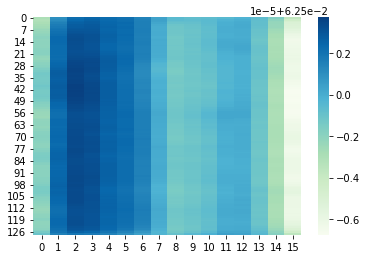

In [91]:
plot_attention(attn_wts[32].cpu().detach().numpy())

In [117]:
optimizer.param_groups[0]['lr'] = 1e-4


Epoch: 1/50


Train:   0%|          | 0/1214 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


	Train Loss 0.4939	 Learning Rate 0.0001000
Val Loss 0.6043
(0.7309654235958015, 0.7637096729774026, 0.4052885026357031)


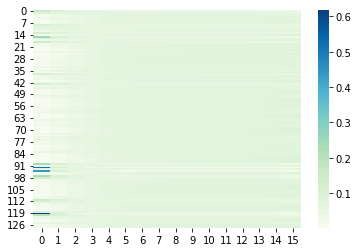


Epoch: 2/50


	Train Loss 0.4867	 Learning Rate 0.0001000
Val Loss 0.6193
(0.733926386386283, 0.7607112094888736, 0.40461914023049533)


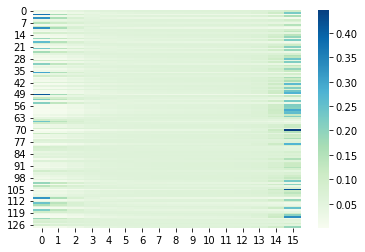


Epoch: 3/50


	Train Loss 0.4820	 Learning Rate 0.0000500
Val Loss 0.6213
(0.7322251880611502, 0.7591500882868119, 0.40286164498579535)


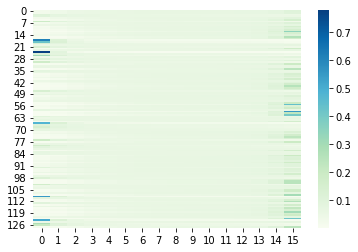


Epoch: 4/50


	Train Loss 0.4794	 Learning Rate 0.0000500
Val Loss 0.6305
(0.725567539380547, 0.7585289742815694, 0.40162616254877925)


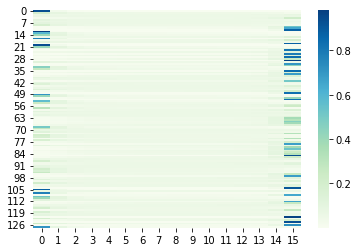


Epoch: 5/50


	Train Loss 0.4772	 Learning Rate 0.0000500
Val Loss 0.6328
(0.7234842813405133, 0.7561290813639882, 0.39867903158886253)


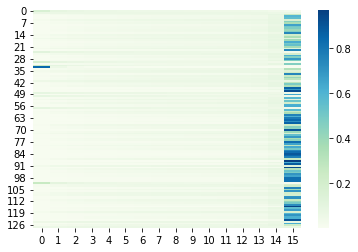


Epoch: 6/50


	Train Loss 0.4750	 Learning Rate 0.0000500
Val Loss 0.6413
(0.7233113218749838, 0.7559379236996425, 0.399065792200373)


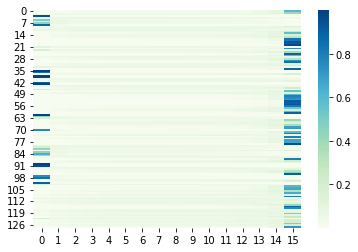


Epoch: 7/50


	Train Loss 0.4728	 Learning Rate 0.0000250
Val Loss 0.6353
(0.7192790429920438, 0.7539577772134405, 0.3969421670729005)


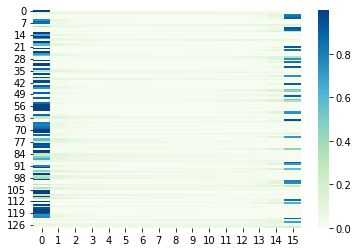


Epoch: 8/50


	Train Loss 0.4716	 Learning Rate 0.0000250
Val Loss 0.6539
(0.7236830556516441, 0.7537483028336055, 0.3982857110760365)


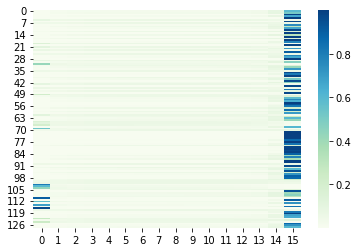


Epoch: 9/50


Train:   0%|          | 6/1214 [00:04<12:47,  1.57it/s, loss=0.4682, lr=0.000025]

KeyboardInterrupt: ignored

In [118]:
torch.cuda.empty_cache()
gc.collect()

for epoch in range(0, 50):

    print("\nEpoch: {}/{}".format(epoch+1, 50))
    
    curr_lr = optimizer.param_groups[0]['lr']

    train_loss, attn_wts = train_model(model, train_loader, criterion, optimizer) 
    valid_loss, val_results, attn_val_wts  = validate_model(model, val_loader)
    
    scheduler.step(valid_loss)

    print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}".format(train_loss, curr_lr))
    print("Val Loss {:.04f}".format(valid_loss))
    res = np.stack(val_results, axis = 0)
    print(evaluate_metrics(actual, res[:,1]))

    # Plot Attention for a single item in the batch
    plot_attention(attn_wts[0].cpu().detach().numpy())


    # wandb.log({
    #     'train_loss': train_loss,  
    #     'valid_dist': valid_dist, 
    #     'valid_loss': valid_loss, 
    #     'lr'        : curr_lr
    # })
    
#     save_model(model, optimizer, scheduler, ['valid_dist', valid_dist], epoch, epoch_model_path)
#     wandb.save(epoch_model_path)
#     print("Saved epoch model")

#     if valid_dist <= best_lev_dist:
#         best_lev_dist = valid_dist
#         save_model(model, optimizer, scheduler, ['valid_dist', valid_dist], epoch, best_model_path)
#         wandb.save(best_model_path)
#         print("Saved best model")
#       # You may find it interesting to exlplore Wandb Artifcats to version your models
# run.finish()

In [ ]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

In [ ]:
results = []
sigmoid = torch.nn.Sigmoid()
model.eval()
for data in tqdm(val_loader):

    x_encoder,x_decoder,y_encoder,y_decoder,lx_encoder,lx_decoder, ly_encoder, ly_decoder = data
    x_encoder,x_decoder,y_encoder,y_decoder = x_encoder.to(device),x_decoder.to(device),y_encoder.to(device),y_decoder.to(device)

    with torch.no_grad():
        decoder_out = model(x_encoder,lx_encoder,y_encoder,x_decoder,lx_decoder)
        decoder_out = sigmoid(decoder_out)

    #prediction_string = decode_prediction(h, lh, decoder, PHONEME_MAP=LABELS) # TODO call decode_prediction 
    #TODO save the output in results array.
    i = 0
    for out in decoder_out.detach().cpu().numpy():
      out1 = out[0:lx_decoder[i]]
      results.extend(out1)
      i+=1
    
    del x_encoder,x_decoder,y_encoder,y_decoder,lx_encoder,lx_decoder, ly_encoder, ly_decoder,decoder_out 
    torch.cuda.empty_cache()

Extra


In [ ]:
# class ExcerciseToken(object):
#   def __init__(self, token, id, pos_tag, morphological_features, dep_label, dep_edge_head):
#     self.token = token
#     self.id = id
#     self.pos_tag = pos_tag
#     self.morphological_features = morphological_features
#     self.dep_label = dep_label
#     self.dep_edge_head = dep_edge_head
  
#   def set_label(self, label):
#     self.label = label


In [ ]:
# class ExcerciseInformation(object):
#   def __init__(self):
#     self.exercise_tokens = []
#     self.prompt = ""
#     self.user = ""
#     self.countries = ""
#     self.days = 0.0
#     self.client = ""
#     self.session = ""
#     self.format = ""
#     self.time = 0.0
  
#   def add_exercise_token(self, excercise_token_info: ExcerciseToken):
#     self.exercise_tokens.append(excercise_token_info)
  
#   def set_prompt(self, prompt: str):
#     self.prompt = prompt

#   def set_user(self, user: str):
#     self.user = user
  
#   def set_countries(self, countries: str):
#     self.countries = countries

#   def set_days(self, days: float):
#     self.days = days
  
#   def set_client(self, client: str):
#     self.client = client
  
#   def set_session(self, session: str):
#     self.session = session
  
#   def set_format(self, format: str):
#     self.format = format

#   def set_time(self, time: float):
#     self.time = time
  

